<a href="https://colab.research.google.com/github/nirmal-ank/GNN/blob/main/5_NodeClassificationOnCoraDataUsingGCNAndGAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

In [1]:
import os
import torch

print(torch.__version__)

2.5.1+cu121


In [2]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s eta 0:00:00


In [3]:
import torch_geometric

torch_geometric.__version__

'2.6.1'

##### Loading Cora dataset from Planetoid.

https://graphsandnetworks.com/the-cora-dataset/

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 10556 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

##### Normalize features
Row-normalizes the attributes given in attrs to sum-up to one (functional name: normalize_features).

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

cora_dataset = Planetoid(root = "Cora_data", name = "Cora", transform = NormalizeFeatures())

Processing...
Done!


In [5]:
len(cora_dataset)

1

In [6]:
cora_dataset.num_features

1433

In [7]:
cora_graph = cora_dataset[0]

cora_graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
print(len(cora_graph.x[0]))

cora_graph.x[0]

1433


tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [9]:
print("Training samples: ", cora_graph.train_mask.sum().item())
print("Validation samples: ", cora_graph.val_mask.sum().item())
print("Test samples: ", cora_graph.test_mask.sum().item())

Training samples:  140
Validation samples:  500
Test samples:  1000


In [10]:
print(f'Number of nodes: {cora_graph.num_nodes}')
print(f'Number of edges: {cora_graph.num_edges}')
print(f'Average node degree: {cora_graph.num_edges / cora_graph.num_nodes:.2f}')
print(f'Has isolated nodes: {cora_graph.has_isolated_nodes()}')
print(f'Has self-loops: {cora_graph.has_self_loops()}')
print(f'Is undirected: {cora_graph.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True


The Cora dataset consists of academic publications, where nodes represent documents and edges represent citations between documents. Each document (node) belongs to one of seven classes, representing different research areas. Here are the classes in the Cora dataset:

Case_Based
Genetic_Algorithms
Neural_Networks
Probabilistic_Methods
Reinforcement_Learning
Rule_Learning
Theory

In [11]:
cora_dataset.num_classes

7

In [12]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
}

cora_graph.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


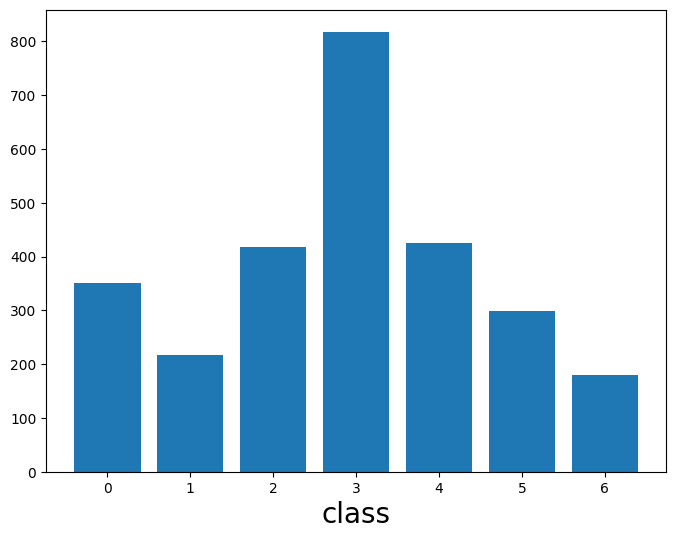

In [13]:
import collections
import matplotlib.pyplot as plt

counter = collections.Counter(cora_graph.y.numpy())
counter = dict(counter)
print(counter)

count = [x[1] for x in sorted(counter.items())]

plt.figure(figsize = (8, 6))
plt.bar(range(7), count)
plt.xlabel("class", size = 20)
plt.show()

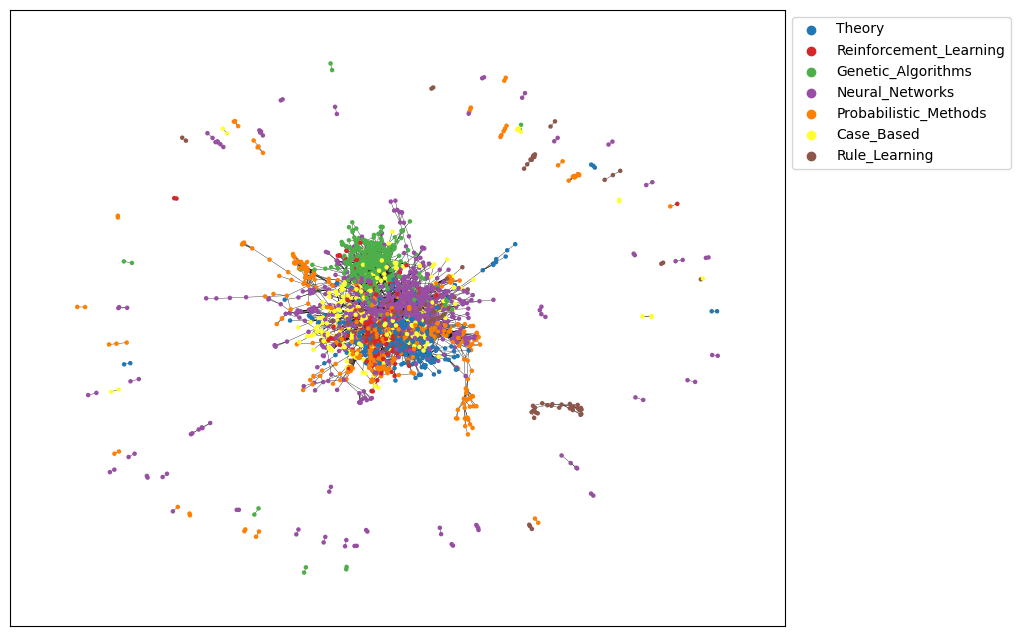

In [14]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Define label names and colors
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
}
colorlist = ['#1f77b4', '#d62728', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#8c564b']

# Convert PyG graph to NetworkX graph
G = to_networkx(cora_graph, to_undirected = True)

# Prepare node colors and legends
node_color = [colorlist[int(label)] for label in cora_graph.y]
labellist = [label_dict[int(label)] for label in cora_graph.y]

# Plot the graph
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 8))

nx.draw_networkx_nodes(G, pos, node_size = 5, node_color = node_color)
nx.draw_networkx_edges(G, pos, width = 0.25)

# Add legends
for label, color in zip(label_dict.values(), colorlist):
    plt.scatter([], [], c = color, label = label)

plt.legend(bbox_to_anchor = (1, 1), loc = "upper left")

plt.show()

To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.
Ref-doc-link-
https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#learning-methods-on-graphs

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels = 16):
        torch.manual_seed(123)

        super().__init__()

        self.conv1 = GCNConv(in_channels = input_channels, out_channels = hidden_channels)
        self.conv2 = GCNConv(in_channels = hidden_channels, out_channels = output_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()

        x = F.dropout(x, p = 0.5, training = self.training)

        x = self.conv2(x, edge_index)

        return x

#### When using GCN network

Configuration is:
- hidden channels=16
- optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)



https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=S-q6Do4INLET

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cora_graph = cora_dataset[0].to(device)

input_channels = cora_dataset.num_features

output_channels = cora_dataset.num_classes

In [ ]:
# model = GAT(
#     input_channels = input_channels,
#     output_channels = output_channels
# ).to(device)

In [17]:
model = GCN(
    input_channels = input_channels,
    output_channels = output_channels
).to(device)

print(model)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Number of parameters:  23063


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components = 2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize = (10, 8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s = 70, c = color, cmap = "Set2")
    plt.show()

Node embedding shape: torch.Size([2708, 7])


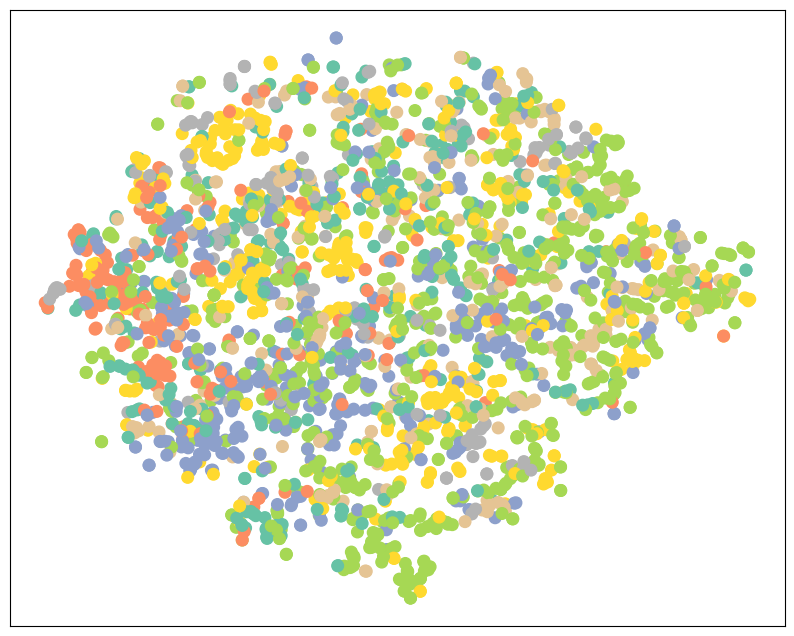

In [19]:
model.eval()
out = model(cora_graph)

print("Node embedding shape:", out.shape)
visualize(out, color = cora_graph.cpu().y)

#### When using GCN network

Configuration is:
- hidden channels=16
- optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

#### While using GAT network ,

Configuration is:
- hidden channels=8
- optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay = 5e-4).

In [ ]:
# model = GAT(
#     input_channels = input_channels,
#     output_channels = output_channels
# ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay = 5e-4)

# criterion = nn.CrossEntropyLoss()

In [20]:
model = GCN(
    input_channels = input_channels,
    output_channels = output_channels
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

criterion = nn.CrossEntropyLoss()

In [22]:
%%time
num_epochs = 200
cora_graph = cora_dataset[0].to(device)

for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    out = model(cora_graph)

    loss = criterion(out[cora_graph.train_mask], cora_graph.y[cora_graph.train_mask])
    loss.backward()

    optimizer.step()

    # Get predictions on the training data
    pred_train = out.argmax(dim = 1)

    correct_train = (
        pred_train[cora_graph.train_mask] == cora_graph.y[cora_graph.train_mask]
    ).sum()

    acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

    # Print training loss
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1:03d}, Train Loss: {loss:.3f}, Train Acc: {acc_train:.3f}")

Epoch: 010, Train Loss: 1.846, Train Acc: 0.707
Epoch: 020, Train Loss: 1.698, Train Acc: 0.793
Epoch: 030, Train Loss: 1.508, Train Acc: 0.814
Epoch: 040, Train Loss: 1.261, Train Acc: 0.900
Epoch: 050, Train Loss: 1.090, Train Acc: 0.907
Epoch: 060, Train Loss: 0.908, Train Acc: 0.900
Epoch: 070, Train Loss: 0.772, Train Acc: 0.936
Epoch: 080, Train Loss: 0.620, Train Acc: 0.957
Epoch: 090, Train Loss: 0.592, Train Acc: 0.936
Epoch: 100, Train Loss: 0.541, Train Acc: 0.950
Epoch: 110, Train Loss: 0.467, Train Acc: 0.964
Epoch: 120, Train Loss: 0.435, Train Acc: 0.964
Epoch: 130, Train Loss: 0.422, Train Acc: 0.964
Epoch: 140, Train Loss: 0.367, Train Acc: 0.986
Epoch: 150, Train Loss: 0.403, Train Acc: 0.957
Epoch: 160, Train Loss: 0.365, Train Acc: 0.979
Epoch: 170, Train Loss: 0.381, Train Acc: 0.957
Epoch: 180, Train Loss: 0.360, Train Acc: 0.979
Epoch: 190, Train Loss: 0.340, Train Acc: 0.971
Epoch: 200, Train Loss: 0.317, Train Acc: 0.993
CPU times: user 848 ms, sys: 110 ms, tot

In [23]:
model.eval()

with torch.no_grad():
    pred = model(cora_graph).argmax(dim = 1)

    correct = (pred[cora_graph.test_mask] == cora_graph.y[cora_graph.test_mask]).sum().item()

    test_acc = correct / cora_graph.test_mask.sum().item()

print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8080


In [25]:
model = GCN(
    input_channels = input_channels,
    output_channels = output_channels
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

criterion = nn.CrossEntropyLoss()

In [26]:
%%time

import copy

num_epochs = 200

# Keep track of best validation accuracy and best model state
best_acc_val = 0.0
best_model_state = None

for epoch in range(num_epochs):

    model.train()
    optimizer.zero_grad()

    out = model(cora_graph)

    loss = criterion(out[cora_graph.train_mask], cora_graph.y[cora_graph.train_mask])
    loss.backward()

    optimizer.step()

    # Get predictions on the training data
    pred_train = out.argmax(dim = 1)

    correct_train = (
        pred_train[cora_graph.train_mask] == cora_graph.y[cora_graph.train_mask]
    ).sum()

    acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

    # Get predictions on validation data
    model.eval()

    with torch.no_grad():
        pred_val = model(cora_graph).argmax(dim = 1)

        correct_val = (
            pred_val[cora_graph.val_mask] == cora_graph.y[cora_graph.val_mask]
        ).sum()

        acc_val = int(correct_val) / int(cora_graph.val_mask.sum())

    # Check if the current validation accuracy is the best so far
    if acc_val > best_acc_val:
        best_acc_val = acc_val

        # Update the best model state (deep copy)
        best_model_state = copy.deepcopy(model.state_dict())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1:03d}, \
               Train Loss: {loss:.3f}, \
               Train Acc: {acc_train:.3f} Val Acc: {acc_val:.3f}')

Epoch: 010,                Train Loss: 1.846,                Train Acc: 0.707 Val Acc: 0.606
Epoch: 020,                Train Loss: 1.698,                Train Acc: 0.793 Val Acc: 0.660
Epoch: 030,                Train Loss: 1.508,                Train Acc: 0.814 Val Acc: 0.706
Epoch: 040,                Train Loss: 1.261,                Train Acc: 0.900 Val Acc: 0.756
Epoch: 050,                Train Loss: 1.090,                Train Acc: 0.907 Val Acc: 0.764
Epoch: 060,                Train Loss: 0.908,                Train Acc: 0.900 Val Acc: 0.780
Epoch: 070,                Train Loss: 0.772,                Train Acc: 0.936 Val Acc: 0.792
Epoch: 080,                Train Loss: 0.620,                Train Acc: 0.957 Val Acc: 0.800
Epoch: 090,                Train Loss: 0.592,                Train Acc: 0.936 Val Acc: 0.794
Epoch: 100,                Train Loss: 0.541,                Train Acc: 0.950 Val Acc: 0.792
Epoch: 110,                Train Loss: 0.467,                Train Acc

In [27]:
print("Best validation accuracy: ", best_acc_val)

model.load_state_dict(best_model_state)

Best validation accuracy:  0.804


<All keys matched successfully>

To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set. The Cora dataset provides a validation node set as data.val_mask, but we haven't used it yet. Here we are selecting and testing the model with the highest validation performance.Note that GCN model training is faster than GAT model training

 Test the best model

In [28]:
model.eval()
pred = model(cora_graph).argmax(dim = 1)
correct = (pred[cora_graph.test_mask] == cora_graph.y[cora_graph.test_mask]).sum().item()

test_acc = correct / cora_graph.test_mask.sum().item()

print(f'Best Test Accuracy: {test_acc:.3f}')

Best Test Accuracy: 0.817


Let's visualize the node embeddings of our **trained** network.Clustering looks good.




Node embedding shape: torch.Size([2708, 7])


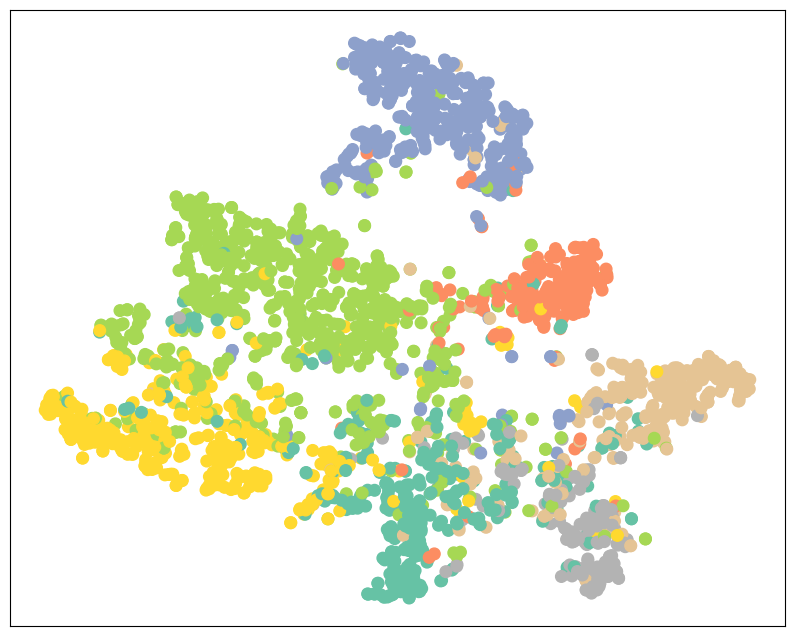

In [29]:
model.eval()

out = model(cora_graph)

print("Node embedding shape:", out.shape)

visualize(out, color = cora_graph.cpu().y)

## Using GAT
We swap out all GCNConv instances with GATConv layers that make use of attention. Building a 2-layer GAT model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer , also using  a dropout ratio of 0.6 inside and outside each GATConv call, and  a hidden_channels dimensions of 8 per head. Document link-
https://towardsdatascience.com/graph-attention-networks-in-python-975736ac5c0c


In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import  GATConv

# class GAT(torch.nn.Module):
#     def __init__(self, input_channels, output_channels, hidden_channels = 8, num_heads = 8):
#         super().__init__()
#         torch.manual_seed(123456)

#         self.gatconv1 = GATConv(
#             in_channels = input_channels,
#             out_channels = hidden_channels,
#             heads = num_heads
#         )

#         self.gatconv2 = GATConv(
#             in_channels = hidden_channels * num_heads,
#             out_channels = output_channels,
#             heads = 1
#         )

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = F.dropout(x, p = 0.6, training = self.training)

#         x = self.gatconv1(x, edge_index)
#         x = F.elu(x)

#         x = F.dropout(x, p = 0.6, training = self.training)
#         x = self.gatconv2(x, edge_index)

#         return x

What we talked about so far is the GatConv layer, but in 2021 Brody et al. introduced an improvement by modifying the order of operations. The weight matrix 𝐖 is applied after the concatenation, and the attention weight matrix 𝐖ₐₜₜ is used after the LeakyReLU function.
Which one should you use? According to Brody et al., Gatv2Conv consistently outperforms GatConv and thus should be preferred.

In [30]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels = 8, num_heads = 8):
        super().__init__()
        torch.manual_seed(123456)

        self.gatconv1 = GATv2Conv(
            in_channels = input_channels,
            out_channels = hidden_channels,
            heads = num_heads
        )

        self.gatconv2 = GATv2Conv(
            in_channels = hidden_channels * num_heads,
            out_channels = output_channels,
            heads = 1
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p = 0.6, training = self.training)

        x = self.gatconv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p = 0.6, training = self.training)
        x = self.gatconv2(x, edge_index)

        return x

#### While using GAT network ,

Configuration is:
- hidden channels=8
- optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay = 5e-4).

In [33]:
model = GAT(
    input_channels = input_channels,
    output_channels = output_channels
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay = 5e-4)

criterion = nn.CrossEntropyLoss()

In [34]:
%%time
num_epochs = 200
cora_graph = cora_dataset[0].to(device)

for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    out = model(cora_graph)

    loss = criterion(out[cora_graph.train_mask], cora_graph.y[cora_graph.train_mask])
    loss.backward()

    optimizer.step()

    # Get predictions on the training data
    pred_train = out.argmax(dim = 1)

    correct_train = (
        pred_train[cora_graph.train_mask] == cora_graph.y[cora_graph.train_mask]
    ).sum()

    acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

    # Print training loss
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1:03d}, Train Loss: {loss:.3f}, Train Acc: {acc_train:.3f}")

Epoch: 010, Train Loss: 1.855, Train Acc: 0.693
Epoch: 020, Train Loss: 1.709, Train Acc: 0.857
Epoch: 030, Train Loss: 1.542, Train Acc: 0.871
Epoch: 040, Train Loss: 1.283, Train Acc: 0.893
Epoch: 050, Train Loss: 1.035, Train Acc: 0.957
Epoch: 060, Train Loss: 0.824, Train Acc: 0.907
Epoch: 070, Train Loss: 0.689, Train Acc: 0.929
Epoch: 080, Train Loss: 0.530, Train Acc: 0.929
Epoch: 090, Train Loss: 0.490, Train Acc: 0.950
Epoch: 100, Train Loss: 0.403, Train Acc: 0.936
Epoch: 110, Train Loss: 0.396, Train Acc: 0.964
Epoch: 120, Train Loss: 0.348, Train Acc: 0.950
Epoch: 130, Train Loss: 0.289, Train Acc: 0.971
Epoch: 140, Train Loss: 0.297, Train Acc: 0.964
Epoch: 150, Train Loss: 0.259, Train Acc: 0.979
Epoch: 160, Train Loss: 0.243, Train Acc: 0.979
Epoch: 170, Train Loss: 0.241, Train Acc: 0.971
Epoch: 180, Train Loss: 0.255, Train Acc: 0.971
Epoch: 190, Train Loss: 0.253, Train Acc: 0.971
Epoch: 200, Train Loss: 0.241, Train Acc: 0.979
CPU times: user 1.4 s, sys: 21.6 ms, tot

In [35]:
model.eval()

with torch.no_grad():
    pred = model(cora_graph).argmax(dim = 1)

    correct = (pred[cora_graph.test_mask] == cora_graph.y[cora_graph.test_mask]).sum().item()

    test_acc = correct / cora_graph.test_mask.sum().item()

print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


In [36]:
model = GAT(
    input_channels = input_channels,
    output_channels = output_channels
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay = 5e-4)

criterion = nn.CrossEntropyLoss()

In [39]:
%%time

import copy

num_epochs = 200

# Keep track of best validation accuracy and best model state
best_acc_val = 0.0
best_model_state = None

for epoch in range(num_epochs):

    model.train()
    optimizer.zero_grad()

    out = model(cora_graph)

    loss = criterion(out[cora_graph.train_mask], cora_graph.y[cora_graph.train_mask])
    loss.backward()

    optimizer.step()

    # Get predictions on the training data
    pred_train = out.argmax(dim = 1)

    correct_train = (
        pred_train[cora_graph.train_mask] == cora_graph.y[cora_graph.train_mask]
    ).sum()

    acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

    # Get predictions on validation data
    model.eval()

    with torch.no_grad():
        pred_val = model(cora_graph).argmax(dim = 1)

        correct_val = (
            pred_val[cora_graph.val_mask] == cora_graph.y[cora_graph.val_mask]
        ).sum()

        acc_val = int(correct_val) / int(cora_graph.val_mask.sum())

    # Check if the current validation accuracy is the best so far
    if acc_val > best_acc_val:
        best_acc_val = acc_val

        # Update the best model state (deep copy)
        best_model_state = copy.deepcopy(model.state_dict())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1:03d}, \
               Train Loss: {loss:.3f}, \
               Train Acc: {acc_train:.3f} Val Acc: {acc_val:.3f}')

Epoch: 010,                Train Loss: 0.276,                Train Acc: 0.964 Val Acc: 0.788
Epoch: 020,                Train Loss: 0.252,                Train Acc: 0.957 Val Acc: 0.792
Epoch: 030,                Train Loss: 0.224,                Train Acc: 0.964 Val Acc: 0.780
Epoch: 040,                Train Loss: 0.211,                Train Acc: 0.979 Val Acc: 0.784
Epoch: 050,                Train Loss: 0.185,                Train Acc: 0.979 Val Acc: 0.798
Epoch: 060,                Train Loss: 0.185,                Train Acc: 0.993 Val Acc: 0.778
Epoch: 070,                Train Loss: 0.187,                Train Acc: 0.986 Val Acc: 0.776
Epoch: 080,                Train Loss: 0.234,                Train Acc: 0.964 Val Acc: 0.806
Epoch: 090,                Train Loss: 0.201,                Train Acc: 0.964 Val Acc: 0.788
Epoch: 100,                Train Loss: 0.184,                Train Acc: 0.993 Val Acc: 0.800
Epoch: 110,                Train Loss: 0.150,                Train Acc

In [40]:
print("Best validation accuracy: ", best_acc_val)

model.load_state_dict(best_model_state)

Best validation accuracy:  0.824


<All keys matched successfully>

To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set. The Cora dataset provides a validation node set as data.val_mask, but we haven't used it yet. Here we are selecting and testing the model with the highest validation performance.Note that GCN model training is faster than GAT model training

###  Test the best model

In [41]:
model.eval()

pred = model(cora_graph).argmax(dim = 1)
correct = (pred[cora_graph.test_mask] == cora_graph.y[cora_graph.test_mask]).sum().item()

test_acc = correct / cora_graph.test_mask.sum().item()

print(f'Best Test Accuracy: {test_acc:.3f}')

Best Test Accuracy: 0.807


Let's visualize the node embeddings of our **trained** network.Clustering looks good.

Node embedding shape: torch.Size([2708, 7])


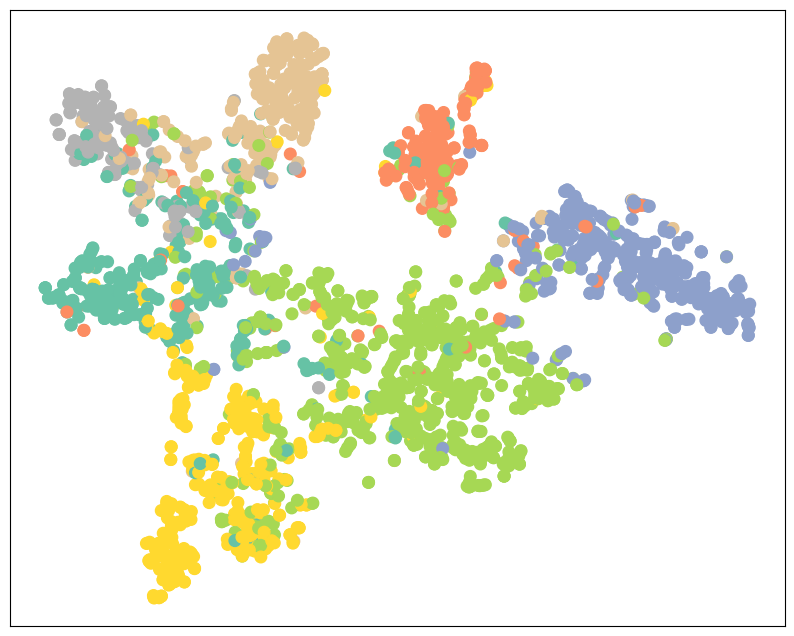

In [42]:
model.eval()

out = model(cora_graph)

print("Node embedding shape:", out.shape)

visualize(out, color = cora_graph.cpu().y)